In [1]:
from __future__ import division, print_function
import time
import torch.utils.data
from torchvision import transforms, datasets
import torchvision
import argparse
import matplotlib

import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
import numpy as np
import os
import sys
try:
    import cPickle as pickle
except:
    import pickle
    

import torch.nn as nn
import torch.nn.functional as F
import copy


from torch.optim.optimizer import Optimizer, required
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import scipy.ndimage as ndim
import matplotlib.colors as mcolors
import pandas as pd
import time
import torch.utils.data
from torchvision import transforms, datasets
import torchvision
import argparse
import matplotlib
from src.Stochastic_Gradient_Langevin_Dynamics.model import *
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer

import collections
import h5py, sys
import gzip
import os
import math
import numpy as np
import pandas as pd

try:
    import cPickle as pickle
except:
    import pickle


import time
import torch.utils.data
from torchvision import transforms, datasets
import torchvision
import matplotlib

In [2]:
image_resize_size = 256
image_trans_size = 224
prior_sig = 0.1
batch_size = 20
nb_epochs = 100
models_dir =  'models_SGLD_COVID150'
# Where to save plots and error, accuracy vectors
results_dir =  'results_SGLD_COVID150'

use_preconditioning = False
lr = 0.0000001



save_data = True
n_samples = batch_size
sample_freq = 2
burn_in = 20
Nsamples = n_samples
save_every = int(nb_epochs/20)  
# We sample every 2 epochs as I have found samples to be correlated after only 1
num_workers = 4
nhid = 1200

transform_covid19 = transforms.Compose([
    transforms.Resize(image_resize_size),
    transforms.CenterCrop(image_trans_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transform_covid19 = transforms.Compose([
#     transforms.Resize(image_trans_size),
#     transforms.CenterCrop(image_trans_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Grayscale(num_output_channels=1)
# ])

In [3]:



def load_object(filename):
    with open(filename, 'rb') as input:
        return pickle.load(input)


def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)


suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']


def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes) - 1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size


def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]


def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out


def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()


def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

class DatafeedImage(data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)


### functions for BNN with gauss output: ###

def diagonal_gauss_loglike(x, mu, sigma):
    # note that we can just treat each dim as isotropic and then do sum
    cte_term = -(0.5)*np.log(2*np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu)/sigma
    dist_term = -(0.5)*(inner**2)
    log_px = (cte_term + det_sig_term + dist_term).sum(dim=1, keepdim=False)
    return log_px

def get_rms(mu, y, y_means, y_stds):
    x_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    return torch.sqrt(((x_un - y_un)**2).sum() / y.shape[0])


def get_loglike(mu, sigma, y, y_means, y_stds):
    mu_un = mu * y_stds + y_means
    y_un = y * y_stds + y_means
    sigma_un = sigma * y_stds
    ll = diagonal_gauss_loglike(y_un, mu_un, sigma_un)
    return ll.mean(dim=0)


In [4]:



class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

In [5]:



def isotropic_gauss_loglike(x, mu, sigma, do_sum=True):
    cte_term = -(0.5) * np.log(2 * np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu) / sigma
    dist_term = -(0.5) * (inner ** 2)

    if do_sum:
        out = (cte_term + det_sig_term + dist_term).sum()  # sum over all weights
    else:
        out = (cte_term + det_sig_term + dist_term)
    return out


class laplace_prior(object):
    def __init__(self, mu, b):
        self.mu = mu
        self.b = b

    def loglike(self, x, do_sum=True):
        if do_sum:
            return (-np.log(2 * self.b) - torch.abs(x - self.mu) / self.b).sum()
        else:
            return (-np.log(2 * self.b) - torch.abs(x - self.mu) / self.b)


class isotropic_gauss_prior(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

        self.cte_term = -(0.5) * np.log(2 * np.pi)
        self.det_sig_term = -np.log(self.sigma)

    def loglike(self, x, do_sum=True):

        dist_term = -(0.5) * ((x - self.mu) / self.sigma) ** 2
        if do_sum:
            return (self.cte_term + self.det_sig_term + dist_term).sum()
        else:
            return (self.cte_term + self.det_sig_term + dist_term)


class spike_slab_2GMM(object):
    def __init__(self, mu1, mu2, sigma1, sigma2, pi):
        self.N1 = isotropic_gauss_prior(mu1, sigma1)
        self.N2 = isotropic_gauss_prior(mu2, sigma2)

        self.pi1 = pi
        self.pi2 = (1 - pi)

    def loglike(self, x):
        N1_ll = self.N1.loglike(x)
        N2_ll = self.N2.loglike(x)

        # Numerical stability trick -> unnormalising logprobs will underflow otherwise
        max_loglike = torch.max(N1_ll, N2_ll)
        normalised_like = self.pi1 * torch.exp(N1_ll - max_loglike) + self.pi2 * torch.exp(N2_ll - max_loglike)
        loglike = torch.log(normalised_like) + max_loglike

        return loglike
    
# class FlattenLayer(ModuleWrapper):

#     def __init__(self, num_features):
#         super(FlattenLayer, self).__init__()
#         self.num_features = num_features

#     def forward(self, x):
#         return x.view(-1, self.num_features)

In [6]:


# class Linear_2L(nn.Module):
#     def __init__(self, input_dim, output_dim, n_hid):
#         super(Linear_2L, self).__init__()

#         self.n_hid = n_hid

#         self.input_dim = input_dim
#         self.output_dim = output_dim

#         self.fc1 = nn.Linear(input_dim, self.n_hid)
#         self.fc2 = nn.Linear(self.n_hid, self.n_hid)
#         self.fc3 = nn.Linear(self.n_hid, output_dim)

#         # choose your non linearity
#         # self.act = nn.Tanh()
#         # self.act = nn.Sigmoid()
#         self.act = nn.ReLU(inplace=True)
#         # self.act = nn.ELU(inplace=True)
#         # self.act = nn.SELU(inplace=True)

#     def forward(self, x):
#         x = x.view(-1, self.input_dim)  # view(batch_size, input_dim)
#         # -----------------
#         x = self.fc1(x)
#         # -----------------
#         x = self.act(x)
#         # -----------------
#         x = self.fc2(x)
#         # -----------------
#         x = self.act(x)
#         # -----------------
#         y = self.fc3(x)

#         return y
    
# class Linear_2L(nn.Module):
#     """
#     To train on CIFAR-10:
#     https://arxiv.org/pdf/1207.0580.pdf
#     """
#     def __init__(self, inputs, outputs, side_in):
#         super(Linear_2L, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(inputs, 32, 5, stride=1, padding=2),
#             nn.Softplus(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(32, 64, 5, stride=1, padding=2),
#             nn.Softplus(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 128, 5, stride=1, padding=1),
#             nn.Softplus(),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.classifier = nn.Sequential(
#             #nn.Flatten()
#             #x.view(-1, 2 * 2 * 128).
#             nn.Linear(int(side_in/8-2) * int(side_in/8-2) * 128, 1000),
#             nn.Softplus(),
#             nn.Linear(1000, 1000),
#             nn.Softplus(),
#             nn.Linear(1000, outputs)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         #print('o',x.size())
#         #print(np.shape(x.cpu().numpy()))
#         x = x.view(-1, x.size()[2] * x.size()[3] * 128)
#         #print('oo',x.size())
#         #print(np.shape(x.cpu().numpy()))
#         x = self.classifier(x)
#         #print('ooo',x.size())
#         #print(np.shape(x.cpu().numpy()))
#         return x
    
class Linear_2L(nn.Module):
    """
    To train on CIFAR-10:
    https://arxiv.org/pdf/1207.0580.pdf
    """
    def __init__(self, inputs, outputs, side_in):
        super(Linear_2L, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(inputs, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, outputs),
        )

    def forward(self, x):
        #print("x", x)
        #plt.imshow(x.cpu())
        #print("shape", np.shape(x.cpu()))
        x = self.features(x)
        #print("x1",x)
        #plt.imshow(x.cpu())
        #print("shape", np.shape(x.cpu()))
        x = self.avgpool(x)
        #print("x2",x)
        #plt.imshow(x.cpu())
        #print("shape", np.shape(x.cpu()))
        x = torch.flatten(x, 1)
        #print("x3",x)
        #plt.imshow(x.cpu())
        #print("shape", np.shape(x.cpu()))
        x = self.classifier(x)
        #print("x4",x)
        #plt.imshow(x.cpu())
        #print("shape", np.shape(x.cpu()))
        return x
    
    
class Net_langevin(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=1, side_in=28, cuda=True, classes=2, N_train=60000, 
                 prior_sig=0, nhid=1200, use_p=False):
        super(Net_langevin, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.prior_sig = prior_sig
        self.classes = classes
        self.N_train = N_train
        self.side_in = side_in
        self.nhid = nhid
        self.use_p = use_p
        self.create_net()
        self.create_opt()
        self.epoch = 0

        self.weight_set_samples = []
        self.test = False

    def create_net(self):
        self.model = Linear_2L(inputs=self.channels_in, outputs=self.classes, side_in=self.side_in)
    #         torch.manual_seed(42)
    #         if self.cuda:
    #             torch.cuda.manual_seed(42)

    #         self.model = Linear_2L(input_dim=self.channels_in * self.side_in * self.side_in, 
    #                                output_dim=self.classes, n_hid=self.nhid)

    #         self.model = Linear_2L(input_dim=self.channels_in * self.side_in * self.side_in, 
    #                                output_dim=self.classes)



        if self.cuda:
            self.model.cuda()
        #             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):

        if self.use_p:
            self.optimizer = pSGLD(params=self.model.parameters(), lr=self.lr, 
                                   norm_sigma=self.prior_sig, addnoise=True)
        else:
            self.optimizer = SGLD(params=self.model.parameters(), lr=self.lr, 
                                  norm_sigma=self.prior_sig, addnoise=True)

            self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        #print("before", self.optimizer)
        self.optimizer.zero_grad()

        out = self.model(x)
#         print("-------------------------------------------------------------")
#         for i in self.model.parameters():
#             print(i.data)
        #print(x)
        #print("after zero_grad(", self.optimizer)
#         print(out)
        #print(y)
        # We use mean because we treat the loss as an estimation of whole dataset's likelihood
        loss = F.cross_entropy(out, y, reduction='mean')
#         print("loss", loss)
        loss = loss * self.N_train  # We scale the loss to represent the whole dataset
        #print("loss2", loss, self.N_train)
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        #print('pred', pred)
        err = pred.ne(y.data).sum()
        #print("err", err)
        return loss.data * x.shape[0] / self.N_train, err
        #return loss.data * x.shape[0], err

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def save_sampled_net(self, max_samples):

        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)

        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))

        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples))

        return None

    def sample_eval(self, x, y, Nsamples=0, logits=True, train=False):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)

        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = x.data.new(Nsamples, x.shape[0], self.classes)

        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)

        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()

        else:
            mean_out = F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()

            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def all_sample_eval(self, x, y, Nsamples):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)

        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = x.data.new(Nsamples, x.shape[0], self.classes)

        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)

        prob_out = F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out

    def get_weight_samples(self, Nsamples=0):
        weight_vec = []

        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)

        for idx, state_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break

            for key in state_dict.keys():
                if 'weight' in key:
                    weight_mtx = state_dict[key].cpu()
                    for weight in weight_mtx.view(-1):
                        weight_vec.append(weight)

        return np.array(weight_vec)

In [7]:


class SGLD(Optimizer):
    """
    SGLD optimiser based on pytorch's SGD.
    Note that the weight decay is specified in terms of the gaussian prior sigma.
    """

    def __init__(self, params, lr=required, norm_sigma=0, addnoise=True):

        weight_decay = 1 / (norm_sigma ** 2)

        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, weight_decay=weight_decay, addnoise=addnoise)

        super(SGLD, self).__init__(params, defaults)

    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None

        for group in self.param_groups:

            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)

                if group['addnoise']:

                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1) / np.sqrt(group['lr'])
                    p.data.add_(-group['lr'],
                                0.5 * d_p + langevin_noise)
                else:
                    p.data.add_(-group['lr'], 0.5 * d_p)

        return loss


class pSGLD(Optimizer):
    """
    RMSprop preconditioned SGLD using pytorch rmsprop implementation.
    """

    def __init__(self, params, lr=required, norm_sigma=0, alpha=0.99, eps=1e-8, centered=False, addnoise=True):

        weight_decay = 1 / (norm_sigma ** 2)

        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr, weight_decay=weight_decay, alpha=alpha, eps=eps, centered=centered, addnoise=addnoise)
        super(pSGLD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(pSGLD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('centered', False)

    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None

        for group in self.param_groups:

            weight_decay = group['weight_decay']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['square_avg'] = torch.zeros_like(p.data)
                    if group['centered']:
                        state['grad_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']
                state['step'] += 1

                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)

                # sqavg x alpha + (1-alph) sqavg *(elemwise) sqavg
                square_avg.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)

                if group['centered']:
                    grad_avg = state['grad_avg']
                    grad_avg.mul_(alpha).add_(1 - alpha, d_p)
                    avg = square_avg.cmul(-1, grad_avg, grad_avg).sqrt().add_(group['eps'])
                else:
                    avg = square_avg.sqrt().add_(group['eps'])

                #                 print(avg.shape)
                if group['addnoise']:
                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1) / np.sqrt(group['lr'])
                    p.data.add_(-group['lr'],
                                0.5 * d_p.div_(avg) + langevin_noise / torch.sqrt(avg))

                else:
                    p.data.addcdiv_(-group['lr'], 0.5 * d_p, avg)
        return loss


In [8]:



trainset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/train", 
                                            transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/test", 
                                          transform=transform_covid19)

channels_in = trainset[0][0].size()[0]
classes = np.shape(np.unique(trainset.targets))[0]

train_data_len = len(trainset.targets)
test_data_len = len(valset.targets)
use_cuda = torch.cuda.is_available()
NTrainPoints = train_data_len

# # Where to save models weights
# models_dir = args.models_dir
# # Where to save plots and error, accuracy vectors
# results_dir = args.results_dir

if use_preconditioning == 1:
    models_dir = 'p' + models_dir
    results_dir = 'p' + results_dir

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config


log_interval = 1


# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

# load data

# data augmentation
# transform_train = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])
#
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])
#
# use_cuda = torch.cuda.is_available()
#
# trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
# valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                              shuffle=True, pin_memory=True,num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                            shuffle=False, pin_memory=True,num_workers=num_workers)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                              shuffle=True, pin_memory=False,num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                            shuffle=False, pin_memory=False,num_workers=num_workers)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


########################################################################################

if use_preconditioning == 1:
    net = Net_langevin(lr=lr, channels_in=channels_in, side_in=image_trans_size, cuda=use_cuda, 
                       classes=classes, N_train=NTrainPoints, prior_sig=prior_sig, nhid=nhid, use_p=True)
    pstr = 'p'
    print('pstr')

else:
    net = Net_langevin(lr=lr, channels_in=channels_in, side_in=image_trans_size, cuda=use_cuda, 
                       classes=classes, N_train=NTrainPoints,prior_sig=prior_sig, nhid=nhid, use_p=False)

#Net_langevin(lr=lr, channels_in=1, side_in=image_trans_size, cuda=use_cuda, 
#classes=2, N_train=NTrainPoints, prior_sig=prior_sig)

## ---------------------------------------------------------------------------------------------------------------------
# train
epoch = 0
cprint('c', '\nTrain:')


Data:

Network:

Net:
 Creating Net!! 
    Total params: 57.01M

Train:


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_31124/2671600186.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


In [9]:
start_save = 15

N_saves = 100  # Max number of saves
###################################

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:
        #x = x[:,0,:,:]
        #print(x.cpu().numpy().shape())
        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)
        #print('ccc', cost_pred, nb_samples, len(x))
    #print('i', nb_samples)
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # ---- save weights
    if i >= start_save and i % save_every == 0:
        net.save_sampled_net(max_samples=N_saves)

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

# Save weight samples from the posterior
save_object(net.weight_set_samples, models_dir+'/state_dicts.pkl')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## Save results for plots
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

textsize = 15
marker = 5

  init cost variables:


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_31124/3299698679.py:35: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  d_p.add_(weight_decay, p.data)


it 0/100, Jtr_pred = 0.693159, err = 0.500000,    time: 101.889153 seconds

    Jdev = 0.692979, err = 0.500000

best test error
Writting models_SGLD_COVID150/theta_best.dat

it 1/100, Jtr_pred = 0.693026, err = 0.500000,    time: 62.594764 seconds

    Jdev = 0.693034, err = 0.500000

it 2/100, Jtr_pred = 0.692920, err = 0.501500,    time: 63.052588 seconds

    Jdev = 0.692981, err = 0.500000

it 3/100, Jtr_pred = 0.693063, err = 0.509500,    time: 62.094626 seconds

    Jdev = 0.692899, err = 0.500000

it 4/100, Jtr_pred = 0.692977, err = 0.506000,    time: 62.971226 seconds

    Jdev = 0.692993, err = 0.500000

it 5/100, Jtr_pred = 0.693492, err = 0.516000,    time: 64.087141 seconds

    Jdev = 0.692722, err = 0.498333

best test error
Writting models_SGLD_COVID150/theta_best.dat

it 6/100, Jtr_pred = 0.693218, err = 0.504500,    time: 62.360870 seconds

    Jdev = 0.692555, err = 0.500000

it 7/100, Jtr_pred = 0.693245, err = 0.501000,    time: 62.398122 seconds

    Jdev = 0.692

it 52/100, Jtr_pred = 0.764016, err = 0.460500,    time: 58.585747 seconds

    Jdev = 0.622261, err = 0.336667

it 53/100, Jtr_pred = 0.733045, err = 0.435500,    time: 59.049379 seconds

    Jdev = 0.617620, err = 0.320000

it 54/100, Jtr_pred = 0.754955, err = 0.442000,    time: 58.375096 seconds

    Jdev = 0.619238, err = 0.346667

it 55/100, Jtr_pred = 0.745033, err = 0.448500,    time: 58.703105 seconds

 saving weight samples 9/100
    Jdev = 0.622175, err = 0.351667

it 56/100, Jtr_pred = 0.766872, err = 0.466500,    time: 59.850393 seconds

    Jdev = 0.631406, err = 0.328333

it 57/100, Jtr_pred = 0.732546, err = 0.426500,    time: 59.044262 seconds

    Jdev = 0.642526, err = 0.370000

it 58/100, Jtr_pred = 0.773961, err = 0.460500,    time: 60.637270 seconds

    Jdev = 0.632067, err = 0.330000

it 59/100, Jtr_pred = 0.769448, err = 0.458000,    time: 59.816415 seconds

    Jdev = 0.633562, err = 0.361667

it 60/100, Jtr_pred = 0.770120, err = 0.462500,    time: 58.631305 

C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_31124/2671600186.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_31124/2542181615.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(results_dir + '/err.png', bbox_extra_artists=(lgd,), box_inches='tight')


<Figure size 600x400 with 0 Axes>

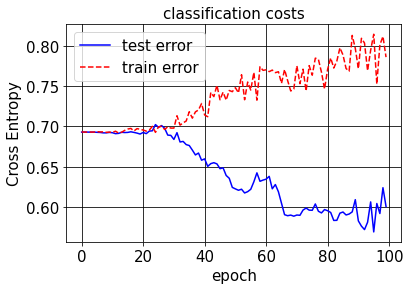

<Figure size 600x400 with 0 Axes>

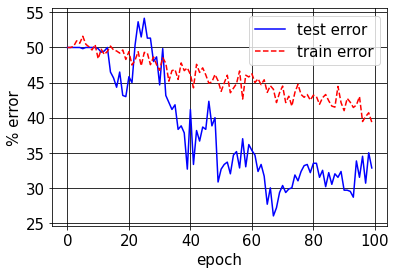

In [10]:
plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.plot(pred_cost_train, 'r--')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.plot(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.plot(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png', bbox_extra_artists=(lgd,), box_inches='tight')

In [11]:
torch.cuda.empty_cache()

# prediction

In [12]:




trainset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/train", transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="./notebooks/data/COVID/test", transform=transform_covid19)

train_data_len = len(trainset.targets)
test_data_len = len(valset.targets)
use_cuda = torch.cuda.is_available()
NTrainPoints = train_data_len


if use_preconditioning == 1:
    print('ccccc')
    models_dir = 'p' + models_dir
    results_dir = 'p' + results_dir


mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
print('models_dir', models_dir)

log_interval = 1


if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                              shuffle=False, pin_memory=True,num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                            shuffle=False, pin_memory=True,num_workers=num_workers)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                              shuffle=False, pin_memory=False,num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                            shuffle=False, pin_memory=False, num_workers=num_workers)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


########################################################################################
if use_preconditioning == 1:
    net = Net_langevin(lr=lr, channels_in=channels_in, side_in=image_trans_size, 
                       cuda=use_cuda, classes=classes, N_train=NTrainPoints,prior_sig=prior_sig, 
                       nhid=nhid, use_p=True)
    pstr = 'p'
    print('predict pSGLD in')
else:
    net = Net_langevin(lr=lr, channels_in=channels_in, side_in=image_trans_size, 
                       cuda=use_cuda, classes=classes, N_train=NTrainPoints,prior_sig=prior_sig, 
                       nhid=nhid, use_p=False)
    print("predict SGLD in")

if use_preconditioning == 1:
    pstr = 'p'
    with open(models_dir + '/state_dicts.pkl', 'rb') as input:
        net.weight_set_samples = pickle.load(input)
else:
    with open(models_dir + '/state_dicts.pkl', 'rb') as input:
        net.weight_set_samples = pickle.load(input)

if use_cuda:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=num_workers)

else:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=num_workers)
test_cost = 0  # Note that these are per sample
test_err = 0
nb_samples = 0
test_predictions = np.zeros((test_data_len, classes))



net.set_mode_train(False)

for j, (x, y) in enumerate(valloader):
    cost, err, probs = net.sample_eval(x, y, Nsamples, logits=False) # , logits=True
    #print('nettttttttttttttttttttttttttttttttttt', probs)
    test_cost += cost
    test_err += err.cpu().numpy()
    test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
    nb_samples += len(x)

# test_cost /= nb_samples
test_err /= nb_samples
cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))




models_dir models_SGLD_COVID150

Network:

Net:
 Creating Net!! 


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_31124/2671600186.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


    Total params: 57.01M
predict SGLD in
    Loglike = -377.276703, err = 0.283333



In [13]:
x_dev = []
y_dev = []
for x, y in valloader:
    x_dev.append(x.cpu().numpy())
    y_dev.append(y.cpu().numpy())

x_dev = np.concatenate(x_dev)
y_dev = np.concatenate(y_dev)
#print(x_dev.shape)
#print(y_dev.shape)

im_ind = np.random.randint(0, y_dev.shape[0])
#im_ind = 90
print("image number:", im_ind)


x, y = x_dev[im_ind], y_dev[im_ind]
#x_rot = np.expand_dims(ndim.interpolation.rotate(x[:, :, :], 0, reshape=False, cval=-0.42421296), 0)

print("real number:", y)

#plt.imshow(ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))


ims=[]


#ims.append(x_rot[:,:,:])
ims.append(x)


#ims = np.concatenate(ims)

net.set_mode_train(False)

y = np.ones(np.shape(ims)[0])*y
#ims = np.expand_dims(ims, axis=1)
ims = np.array(ims)

cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), 
                                   Nsamples=Nsamples, logits=False) # , logits=True

predictions = probs.numpy()

#print("predictions", predictions)

print("error", err.cpu().numpy())


# predictions.max(axis=1)[0]
# selections = (predictions[:,i] == predictions.max(axis=1))
print("predict", predictions.argmax())

print(im_ind)

#print(valset[im_ind][1])

print(valset.class_to_idx)

image number: 452
real number: 1
error 0
predict 1
452
{'0noncovid': 0, '1covid': 1}


# predict train set

In [14]:
torch.cuda.empty_cache()

In [15]:
x_train_dev = []
y_train_dev = []
for x, y in trainloader:
    x_train_dev.append(x.cpu().numpy())
    y_train_dev.append(y.cpu().numpy())

x_train_dev = np.concatenate(x_train_dev)
y_train_dev = np.concatenate(y_train_dev)

In [16]:
y_true = []
y_pred = []
prob = []
for i in range(0,train_data_len):
    x, y = x_train_dev[i], y_train_dev[i]
    #x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)
    #print("real number:",y)
    y_true.append(y)
    #plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
    #plt.show()
    ims=[]
    #ims.append(x_rot[:,:,:])
    ims.append(x)
    #ims = np.concatenate(ims)
    net.set_mode_train(False)
    #y = np.ones(ims.shape[0])*y
    y = np.ones(np.shape(ims)[0])*y
    ims = np.array(ims)
    #ims = np.expand_dims(ims, axis=1)
    #print(y)
    cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True
    predictions = probs.numpy()
    prob.append(predictions)
#     print("predictions", predictions)
#     print("error", err.cpu().numpy())
    y_pred.append(predictions.argmax())
    torch.cuda.empty_cache()

print(y_pred)

prob = np.array(prob)
prob = prob.reshape(train_data_len, classes)

if save_data == True:
    save_path = 'SGLD_predict_data'
    if use_preconditioning == 1:
        save_path = pstr + save_path
        print('in pSGLD path', save_path)
    mkdir(save_path)
    file_name = "SGLD_train_epochs=%d_lr=%f_batch_size=%d_image_trans_size=%d.csv" \
                % (nb_epochs, lr, batch_size, image_trans_size)
    completeName = os.path.join(save_path, file_name)
    print('c', completeName)
    if os.path.exists(completeName):
        os.remove(completeName)
    # df = pd.DataFrame(prob)
    # df.to_csv(completeName)
    np.savetxt(completeName, prob, delimiter=",")
    # file1 = open(completeName, "w")
    # for i in range(0, 41):
    #
    #     file1.write(str(prob[i]))
    #     file1.write("\n")
    # file1.close()

#plt.show()

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

# predict test set

In [17]:
torch.cuda.empty_cache()

In [18]:
y_true = []
y_pred = []
prob = []
for i in range(0,test_data_len):
    x, y = x_dev[i], y_dev[i]
    #x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)
    #print("real number:",y)
    y_true.append(y)
    #plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
    #plt.show()
    ims=[]
    #ims.append(x_rot[:,:,:])
    ims.append(x)
    #ims = np.concatenate(ims)
    net.set_mode_train(False)
    #y = np.ones(ims.shape[0])*y
    y = np.ones(np.shape(ims)[0])*y
    ims = np.array(ims)
    #ims = np.expand_dims(ims, axis=1)
    #print(y)
    cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True
    predictions = probs.numpy()
    prob.append(predictions)
#     print("predictions", predictions)
#     print("error", err.cpu().numpy())
    y_pred.append(predictions.argmax())
    torch.cuda.empty_cache()

print(y_pred)

prob = np.array(prob)
prob = prob.reshape(test_data_len, classes)

if save_data == True:
    save_path = 'SGLD_predict_data'
    if use_preconditioning == 1:
        save_path = pstr + save_path
        print('in pSGLD path', save_path)
    mkdir(save_path)
    file_name = "SGLD_epochs=%d_lr=%f_batch_size=%d_image_trans_size=%d.csv" \
                % (nb_epochs, lr, batch_size, image_trans_size)
    completeName = os.path.join(save_path, file_name)
    print('c', completeName)
    if os.path.exists(completeName):
        os.remove(completeName)
    # df = pd.DataFrame(prob)
    # df.to_csv(completeName)
    np.savetxt(completeName, prob, delimiter=",")
    # file1 = open(completeName, "w")
    # for i in range(0, 41):
    #
    #     file1.write(str(prob[i]))
    #     file1.write("\n")
    # file1.close()

#plt.show()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 

In [19]:
torch.cuda.empty_cache()